---
skip_execution: true
---

# Hamiltonian Monte Carlo with CUQIpy-PyTorch



In this notebook, we use [CUQIpy-PyTorch](https://github.com/CUQI-DTU/CUQIpy-PyTorch) to extend CUQIpy by adding the ability to use PyTorch as a backend for array operations. PyTorch enables two main things: 1) GPU acceleration and 2) automatic differentiation. GPU acceleration is self-explanatory, but automatic differentiation deserves some explanation.

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) enables computing the gradient of a function with respect to its input variables automatically using repeated application of the chain rule. This is useful for many machine learning algorithms, but also in the context of Bayesian inference. In particular, it means that we can automatically compute the gradient of a log-posterior, which could be arbitrarily complex! This provides a huge advantage because we can then sample from the posterior distribution using Hamiltonian Monte Carlo (HMC) and other gradient-based methods.

Hamiltonian Monte Carlo and in particular the [No-U-Turn Sampler](https://arxiv.org/abs/1111.4246) (NUTS) variant is a general, but still very efficient sampler for sampling high-dimensional distributions that only requires gradient information. This is useful when it is not possible to exploit the structure of the posterior distribution using e.g. conjugacy relations, linearity of forward models or other tricks, which in large part is what the main CUQIpy package is all about.

In this way, CUQIpy-PyTorch compliments the main CUQIpy package by adding the option for an efficient sampling technique that works for arbitrary posterior distributions by using automatic differentiation to compute the gradient of the log-posterior.

**Make sure you have installed the CUQIpy-PyTorch plugin (link in first paragraph) before starting this exercise.**

## Learning objectives of this notebook:

Going through this notebook, you will learn:

- Why Hamiltonian Monte Carlo is useful for sampling distributions
- The basics of PyTorch tensors
- The basics of CUQIpy-PyTorch distributions
- How to use Hamiltonian Monte Carlo to sample from distributions
- How to use Hamiltonian Monte Carlo to sample Bayesian inference problems

## Table of contents: 
* [1. Why Hamiltonian Monte Carlo?](#why-hmc?)
* [2. PyTorch basics and CUQIpy-PyTorch](#pytorch-basics)
* [3. Hamiltonian Monte Carlo in CUQIpy-PyTorch](#hmc-cuqipy-pytorch)
* [4. Bayesian inverse problems with CUQIpy-PyTorch](#bayesian-inverse-problems)
* [5. Open-ended exploration](#open-ended-exploration)

<div style="border: 2px solid #FFB74D; background-color: #FFF3E0; border-radius: 8px; padding: 10px; font-family: Arial, sans-serif; color: #333; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1); max-width: 750px; margin: 0 auto;">
  <strong style="color: #E65100;">⚠️ Note:</strong> 

- This notebook was run on some machine and not using github actions for this book. To run this notebook on your machine, you need to have [CUQIpy-PyTorch installed](https://github.com/CUQI-DTU/CUQIpy-PyTorch).

</div>

First we import the necessary packages. Notice we use the PyTorch package `torch` (imported as `xp`) instead of NumPy for arrays and import both `cuqi` and `cuqipy_pytorch` from CUQIpy and CUQIpy-PyTorch, respectively. We also import `matplotlib` for plotting and some timing utilities.

In [1]:
import torch as xp
import numpy as np
import cuqi
import cuqipy_pytorch
import matplotlib.pyplot as plt
import time

# Disable progress bar dynamic update for cleaner output for the book. You can
# enable it again by setting it to True to monitor sampler progress.
cuqi.config.PROGRESS_BAR_DYNAMIC_UPDATE = False

# 1. Why Hamiltonian Monte Carlo? <a class="anchor" id="why-hmc"></a>

As mentioned in the introduction, Hamiltonian Monte Carlo (HMC) is a general, but still very efficient sampler for sampling high-dimensional distributions. It is beyond the scope of this exercise to go into the details of HMC, but we instead give a short example showing how it compares to using the classical Metropolis-Hastings algorithm. For more details in the theory of HMC, we refer to the [original paper](https://arxiv.org/abs/1206.1901) by Neal and the [No-U-Turn Sampler](https://arxiv.org/abs/1111.4246) (NUTS) variant by Hoffman and Gelman.

Suppose we were aiming to sample from a 2-dimensional probability density function shaped like a donut. We could also have selected a higher dimensional example making Metropolis-Hastings potentially look even worse, but it makes visualization more difficult.

This example can be loaded from the `DistributionGallery` class in CUQIpy as follows.

In [2]:
donut = cuqi.distribution.DistributionGallery('donut')

The donut distribution has a manually derived gradient for the logpdf. For illustration let us plot the pdf and arrows showing the gradient of the pdf at a few points.

Note: Currently there is no `plot_pdf` method for CUQIpy distributions, so we must write our own plotting code. Also at this point we still use NumPy arrays instead of PyTorch tensors and the main CUQIpy package, but we will switch to PyTorch tensors and CUQIpy-PyTorch later.

In [3]:
def plot_pdf(dist, plot_grad=False):
    """ Plot the pdf of a 2-dimensional distribution and optionally its gradient as a vector field. """
    # Ranges for the plot
    m, n, nl, ng = 300, 300, 30, 30
    xmin, xmax, ymin, ymax = -4, 4, -4, 4

    # evaluate PDF
    X, Y = np.meshgrid(np.linspace(xmin, xmax, m), np.linspace(ymin, ymax, n))
    Xf, Yf = X.flatten(), Y.flatten()
    pts = np.vstack([Xf, Yf]).T   # pts is (m*n, d)
    Z = donut.pdf(pts).reshape((m, n))

    if plot_grad:
        # evaluate gradient
        Xg, Yg = np.meshgrid(np.linspace(xmin, xmax, ng), np.linspace(ymin, ymax, ng))
        Xfg, Yfg = Xg.flatten(), Yg.flatten()
        posg = np.vstack([Xfg, Yfg]).T  
        grad = donut.gradient(posg)
        norm = np.linalg.norm(grad, axis=0)
        u, v = grad[0, :]/norm, grad[1, :]/norm

    # plot PDF and gradient
    plt.contourf(X, Y, Z, nl)
    plt.contour(X, Y, Z, nl, linewidths=0.5, colors='k') 
    if plot_grad:
        plt.quiver(posg[:, 0], posg[:, 1], u, v, units='xy', scale=4, color='gray')

We now plot the pdf and gradient arrows using the `plot_pdf` function defined above.

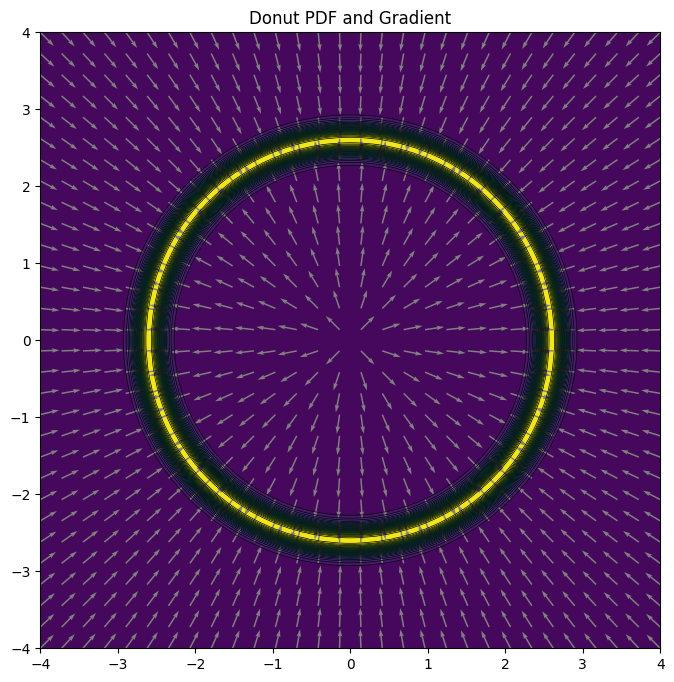

In [4]:
plt.figure(figsize=(8, 8))
plot_pdf(donut, plot_grad=True)
plt.title('Donut PDF and Gradient');

We can now sample from the distribution using both the Metropolis-Hastings algorithm and HMC (NUTS). We also store the time it takes to sample from the distribution using each method.

In [5]:
print("Metropolis-Hastings")
t = time.time()
samples_MH = cuqi.sampler.MH(donut).warmup(1000).sample(2000).get_samples().burnthin(1000)
t_MH = time.time() - t

print("Hamiltonian Monte Carlo (NUTS)")
t = time.time()
samples_NUTS = cuqi.sampler.NUTS(donut).warmup(1000).sample(2000).get_samples().burnthin(1000)
t_NUTS = time.time() - t

Metropolis-Hastings


Sample: 100%|██████████| 2000/2000 [00:00<00:00, 4234.18it/s, acc rate: 20.90%]


Hamiltonian Monte Carlo (NUTS)


Sample: 100%|██████████| 2000/2000 [00:06<00:00, 298.38it/s, acc rate: 94.15%]


We can then compare the samples obtained from the two methods by plotting the samples in a "pair plot" (a scatter plot for each pair of variables).

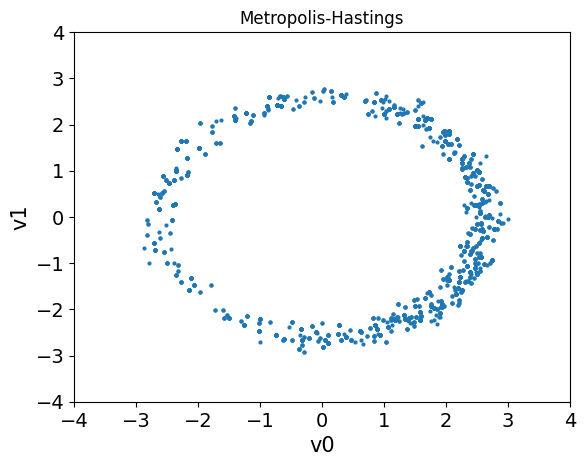

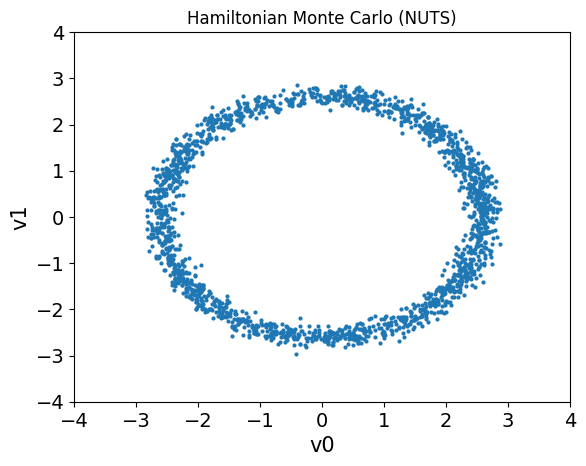

In [6]:
samples_MH.plot_pair()
plt.title('Metropolis-Hastings')
plt.xlim(-4, 4)
plt.ylim(-4, 4)



samples_NUTS.plot_pair()
plt.title('Hamiltonian Monte Carlo (NUTS)')
plt.xlim(-4, 4)
plt.ylim(-4, 4);

Notice that the samples obtained using HMC are much more evenly distributed than the samples obtained using the Metropolis-Hastings algorithm (which may not even have explored the entire distribution yet).

We can also see that the chains obtained using HMC are much less correlated than the chains obtained using the Metropolis-Hastings algorithm.

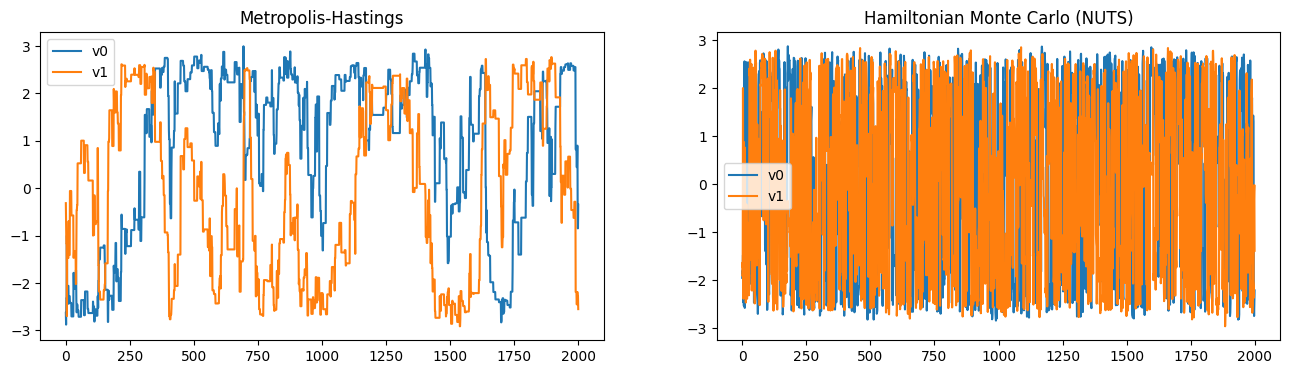

In [7]:
plt.figure(figsize=(16, 4))

plt.subplot(121, title='Metropolis-Hastings')
samples_MH.plot_chain()

plt.subplot(122, title='Hamiltonian Monte Carlo (NUTS)')
samples_NUTS.plot_chain();

Finally, we can compare the effective samples size (ESS) of the two chains. The ESS is a measure of the number of independent samples in a chain. We divide by the total time it took to sample from the distribution to get the effective samples per second (ESS/s). We can see that the ESS/s is (depending on the random number generation) higher for the HMC chain than the Metropolis-Hastings chain.

In [8]:
print(f"MH: Effective samples / second {samples_MH.compute_ess()/t_MH} ")
print(f"NUTS: Effective samples / second {samples_NUTS.compute_ess()/t_NUTS} ")

MH: Effective samples / second [16.63191328 22.42135735] 
NUTS: Effective samples / second [52.18016224 62.32090633] 


There is a lot more to say about HMC, but we will leave that for another time. For now, we will move on to using HMC in CUQIpy-PyTorch.

# 2. PyTorch basics and CUQIpy-PyTorch <a class="anchor" id="pytorch-basics"></a>

**The examples in here are for illustration purposes only. You do not need to understand the all details of automatic differentiation to use CUQIpy-PyTorch.**

In the previous section we used the NUTS implementation from the main CUQIpy package, which requires the gradient of the log-posterior to be manually defined in the `Distribution` class.

In this section we see how to use PyTorch tensors and automatic differentiation to compute the gradient of any distribution. The obvious benefit here is that we do not need to manually define the gradient of the logpdf, which makes the modelling much more flexible.

## PyTorch primer

Before using CUQIpy-PyTorch, we need to learn a bit about PyTorch.

First, we can create a PyTorch tensor in a similar way to NumPy arrays, except we replace `np.array` with `torch.tensor` (or `xp.tensor` if we have imported PyTorch as `xp`).

In [9]:
x = xp.tensor([1, 2, 3], dtype=xp.float32)
print(x)

tensor([1., 2., 3.])


PyTorch mirrors the NumPy API for array operations, so we can use the same operations on PyTorch tensors as we would on NumPy arrays. This includes broadcasting, slicing, indexing as well as most mathematical operations from e.g. the linear algebra sub-package `linalg`.

For example, we can create a matrix and compute the matrix-vector product and then take the 2-norm of the result.

In [10]:
# Matrix
A = xp.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=xp.float32)

# Multiply A with x
y = A@x
print(y)

# Compute norm of A@x
z = xp.linalg.norm(y)
print(z)

tensor([14., 32., 50.])
tensor(60.9918)


### Gradient computation

Any operation involving PyTorch tensors can be differentiated! To use this feature, we need to define each tensor with the `requires_grad` flag set to `True`. This tells PyTorch to keep track of the operations performed on the tensor and to compute the gradient of the tensor with respect to the operations performed on it. For example, from the example above, we can automatically evaluate the gradient of the expression

$$
\|\mathbf{A} \mathbf{x}\|_2^2
$$

with respect to $\mathbf{x}$, for the specific value of $\mathbf{x}=[1,2,3]^T$ as follows.

In [11]:
x = xp.tensor([1, 2, 3], dtype=xp.float32, requires_grad=True) # Say we want to compute gradient wrt x

z = xp.linalg.norm(A@x)**2 # Compute z = ||A@x||^2

# Now evaluate gradient of z wrt x
z.backward() # This will compute dz/dx and store it in x.grad

In [12]:
print(x.grad)

tensor([ 984., 1176., 1368.])


Mathematically we know the gradient is given by

$$
\frac{\partial}{\partial \mathbf{x}} \|\mathbf{A} \mathbf{x}\|_2^2 = 2 \mathbf{A}^T \mathbf{A} \mathbf{x}
$$

which we can verify by comparing to the gradient computed by PyTorch.

In [13]:
2*A.T@A@x

tensor([ 984., 1176., 1368.], grad_fn=<MvBackward0>)

## CUQIpy-PyTorch distributions

Because the `cuqi` distributions are written using NumPy and SciPy, we instead have to use the distributions defined in `cuqipy_pytorch`.

*We are thinking of making the main CUQIpy package agnostic to the backend such that it can use either NumPy or PyTorch (or Jax, or TensorFlow etc.), but this is not yet implemented.*

Instead, we use thin wrappers around PyTorch distributions, that acts as a drop-in replacement for the `cuqi` distributions. They are imported as follows.

In [14]:
from cuqipy_pytorch.distribution import Gaussian, HalfGaussian, Lognormal, Uniform, Gamma, StackedJointDistribution

CUQIpy-PyTorch distributions work in a similar way to the `cuqi` distributions, but instead of using NumPy arrays, they use PyTorch tensors. For example, we can create a 2D i.i.d. Gaussian distribution and look at some of its properties and methods as follows.

In [15]:
x = Gaussian(xp.zeros(2), xp.eye(2))

print(f" Name: {x.name}")
print(f" Mean: {x.mean}")
print(f" Cov: {x.cov}")
print(f" PDF at 0: {x.pdf(xp.zeros(2))}")
print(f" Log PDF at 0: {x.logpdf(xp.zeros(2))}")

 Name: x
 Mean: tensor([0., 0.])
 Cov: tensor([[1., 0.],
        [0., 1.]])
 PDF at 0: 0.1591549664735794
 Log PDF at 0: -1.8378770351409912


The major difference is that the gradient of the logpdf is automatically computed using PyTorch's automatic differentiation feature. We can inspect the code for the `gradient` method to see how this is done. This should look similar to the example we did for PyTorch gradients above.

In [16]:
# Evaluate gradient for some random point
x.gradient(xp.randn(2))

tensor([ 0.4396, -1.5194])

In [17]:
# Inspect the code for evaluating gradient
x.gradient??

Signature: x.gradient(v1, v2=None)
Docstring: Returns the gradient of the log density at x. 
Source:   
    def gradient(self, v1, v2=None):
        if v2 is None:              #Prior case
            v1.requires_grad = True
            v1.grad = None
            Q = self.logpdf(v1)     # Forward pass
            Q.backward()            # Backward pass
            return v1.grad
        else:                       #Likelihood case
            v2.requires_grad = True
            v2.grad = None
            Q = self(v2).logpdf(v1) # Forward pass
            Q.backward()            # Backward pass
            return v2.grad
File:      ~/Documents/research_code/CUQI-DTU/CUQIpy-PyTorch/cuqipy_pytorch/distribution.py
Type:      method

## Really utilizing the power of automatic differentiation

One of the main use-cases for automatic differentiation in the context of Bayesian inference is to compute the gradient of more complex Bayesian models. To illustrate this, suppose one part of the Bayesian model contains a Gaussian distribution with a covariance matrix that is a function of another random variable, say $s$. The Gaussian could be written as follows.

$$
\mathbf{x} \mid s \sim \mathcal{N}(\mathbf{0}, \exp(-s)^2 \mathbf{I}).
$$

In CUQIpy-PyTorch (or CUQIpy), we can define this distribution as follows.

In [18]:
x = Gaussian(xp.zeros(2), lambda s: xp.exp(-s)**2*xp.eye(2))
print(x)

CUQI Gaussian. Conditioning variables ['s'].


To utilize Hamiltonian Monte Carlo to sample from a Bayesian model that contains this distribution, we need to compute the logpdf and gradient respect to $\mathbf{x}$ and $s$! This is where automatic differentiation comes in!

If we define the values of $\mathbf{x}$ and $s$ we want to compute the gradient of the logpdf at, then evaluate the logpdf, we can use the `.backward()` method to compute the gradient of the logpdf with respect to $\mathbf{x}$ and $s$.

In [19]:
# Points to compute gradient at
x_in = xp.ones(2, dtype=xp.float32, requires_grad=True)
s_in = xp.tensor(2, dtype=xp.float32, requires_grad=True)

# Evaluate logpdf
output = x.logd(x=x_in, s=s_in)

# Compute gradient (dlogpdf/dx, dlogpdf/ds)
output.backward()

# Print gradient of logpdf wrt x and s
print(f" Gradient wrt x: {x_in.grad}")
print(f" Gradient wrt s: {s_in.grad}")

 Gradient wrt x: tensor([-54.5982, -54.5982])
 Gradient wrt s: -107.19629669189453


Note that this was an arbitrary expression for the covariance of the Gaussian. You can try to change the expression and see how the gradient changes.

If we compare with the CUQIpy package, we are not able to compute the gradient with respect to $s$, because there is no way to derive the gradient from the user-defined expression using NumPy and SciPy!

In [20]:
# CUQIpy Gaussian
x_cuqi = cuqi.distribution.Gaussian(np.zeros(2), cov=lambda s: np.exp(-s)**2*np.eye(2), name="x")

# Evaluating logpdf goes fine
x_cuqi.logd(x=np.ones(2), s=2)

# We can even get gradient w.r.t x
x_cuqi(s=2).gradient(np.ones(2))

# But not with respect to s! This is because there is a user-defined expression for the covariance that we cant differentiate
#x_cuqi.gradient(x=np.ones(2), s=2) # This wont work

array([-54.59815003, -54.59815003])

# 3. Hamiltonian Monte Carlo with CUQIpy-PyTorch <a class="anchor" id="hmc-cuqipy-pytorch"></a>

We can now use the CUQIpy-PyTorch to define a Bayesian model and use Hamiltonian Monte Carlo to sample from the posterior distribution.

We built the interface to exactly match CUQIpy! The only difference is that we use the `cuqipy_pytorch` package instead of the `cuqi` package.

In the section earlier we already loaded the distributions. What remains is to load a sampler. Here we load a new NUTS sampler, which automatically handles all the details of gradient computation we saw in the previous section, so we do not need to worry about it.


In [21]:
from cuqipy_pytorch.sampler import NUTS

For convenience, let us even define a function that can simply takes our defined Bayesian model and data and uses the NUTS sampler to sample the parameters of the Bayesian model.

In [22]:
# A convenience function to sample a Bayesian model
def sample(*densities, Ns=500, Nb=500, **data):
    """ Sample given by a list of densities. The observations are given as keyword arguments. """
    P = StackedJointDistribution(*densities)
    return NUTS(P(**data)).sample(Ns, Nb)

This function first defines a `cuqi` joint distribution from the given densities, conditions the joint distribution on potential data, then uses the NUTS sampler to sample.

To show how this works let us first sample a case with two independent Gaussian distributions.

\begin{align*}
x &\sim \mathcal{N}(0, 1) \\
y &\sim \mathcal{N}(3, 5)
\end{align*}

This is done as follows.

Sample: 100%|██████████| 1000/1000 [00:03, 265.22it/s, step size=1.07e+00, acc. prob=0.884]


array([[<Axes: title={'center': 'y'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

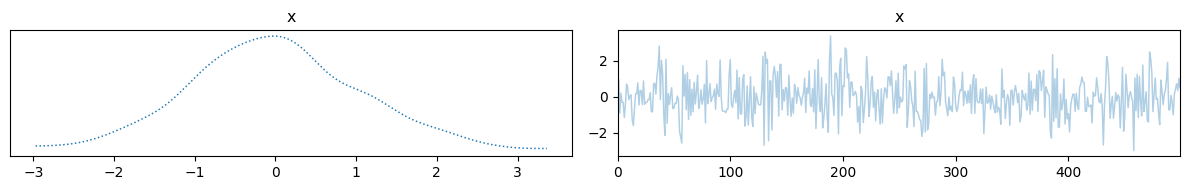

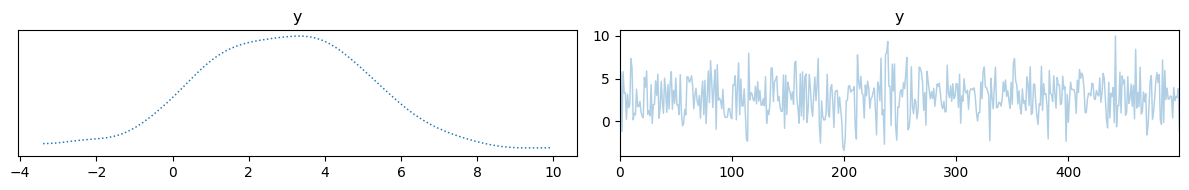

In [23]:
# Bayesian model
x = Gaussian(0, 1)
y = Gaussian(3, 5)

# Sample from the model
samples = sample(x, y)

# Plot the samples
samples["x"].plot_trace()
samples["y"].plot_trace()


We can also define a slightly more complicated model

\begin{align*}
d &\sim \mathrm{Gamma}(1, 1) \\
x &\sim \mathcal{N}(0, \exp(-d)) \\
y &\sim \mathcal{N}(x^2, 5)
\end{align*}

and suppose we observe $y=1$. We can sample from the posterior distribution $p(d, x \mid y=1)$ as follows.

Sample: 100%|██████████| 1000/1000 [00:28, 35.18it/s, step size=8.46e-02, acc. prob=0.931]


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

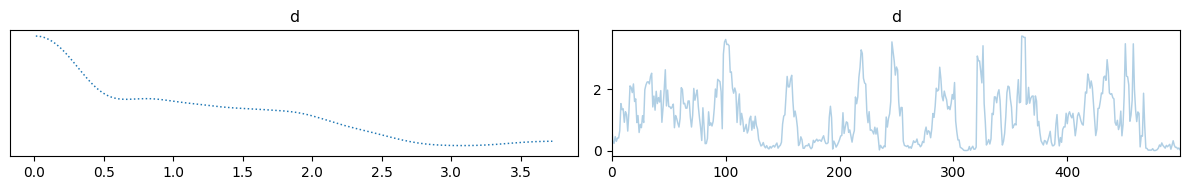

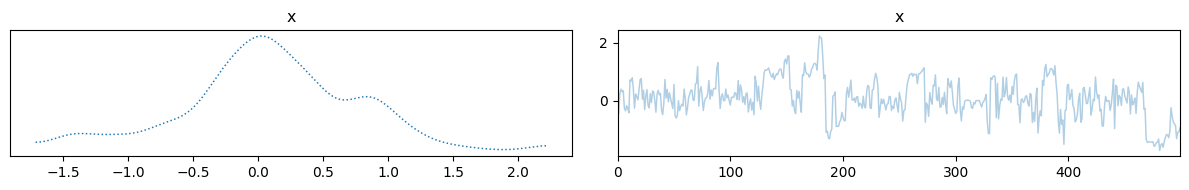

In [24]:
# Define Bayesian model
d = Gamma(1, 1)
x = Gaussian(0, lambda d: xp.exp(-d))
y = Gaussian(lambda x: x**2, 5)

# Sample from the model, given y=1
samples = sample(d, x, y, y=1)

# And plot samples of x and d
samples["d"].plot_trace()
samples["x"].plot_trace()

Hopefully this gives you a good idea of how to use CUQIpy-PyTorch to define Bayesian models and sample from them using Hamiltonian Monte Carlo. We end this section with a classic example of Bayesian inference using Hamiltonian Monte Carlo.

## Eight schools model
The eight schools model is a classic example made famous by the Bayesian Data Analysis book by Gelman et. al. 

It is often used to illustrate the notation and code-style of probabilistic programming languages and whether they are able to handle the model.

The actual model is explained in the BDA book or in the Edward 1.0 PPL notebook ([link](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb)). We do not go into details here.

The Bayesian model can be written as

$$
\begin{align*}
    \mu &\sim \mathcal{N}(0, 10^2)\\
    \tau &\sim \log\mathcal{N}(5, 1)\\
    \boldsymbol \theta' &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}_m)\\
    \boldsymbol \theta &= \mu + \tau \boldsymbol \theta'\\
    \mathbf{y} &\sim \mathcal{N}(\boldsymbol \theta, \boldsymbol \sigma^2 \mathbf{I}_m)
\end{align*}
$$

where $\mathbf{y}\in\mathbb{R}^m$ and $\boldsymbol \sigma\in\mathbb{R}^m$ is observed data.

In CUQIpy-PyTorch we can define the model and sample as follows:

In [25]:
y_obs = xp.tensor([28, 8, -3,  7, -1, 1,  18, 12], dtype=xp.float32)
σ_obs = xp.tensor([15, 10, 16, 11, 9, 11, 10, 18], dtype=xp.float32)

μ     = Gaussian(0, 10**2)
τ     = Lognormal(5, 1)
θp    = Gaussian(xp.zeros(8), 1)
θ     = lambda μ, τ, θp: μ+τ*θp
y     = Gaussian(θ, cov=σ_obs**2)

samples = sample(μ, τ, θp, y, y=y_obs)

Sample: 100%|██████████| 1000/1000 [00:17, 57.83it/s, step size=4.11e-01, acc. prob=0.911]


We can then investigate the posterior samples for $\boldsymbol{\theta}$, $\mu$ and $\tau$ as follows.

[5.6349087]
[12.776174]


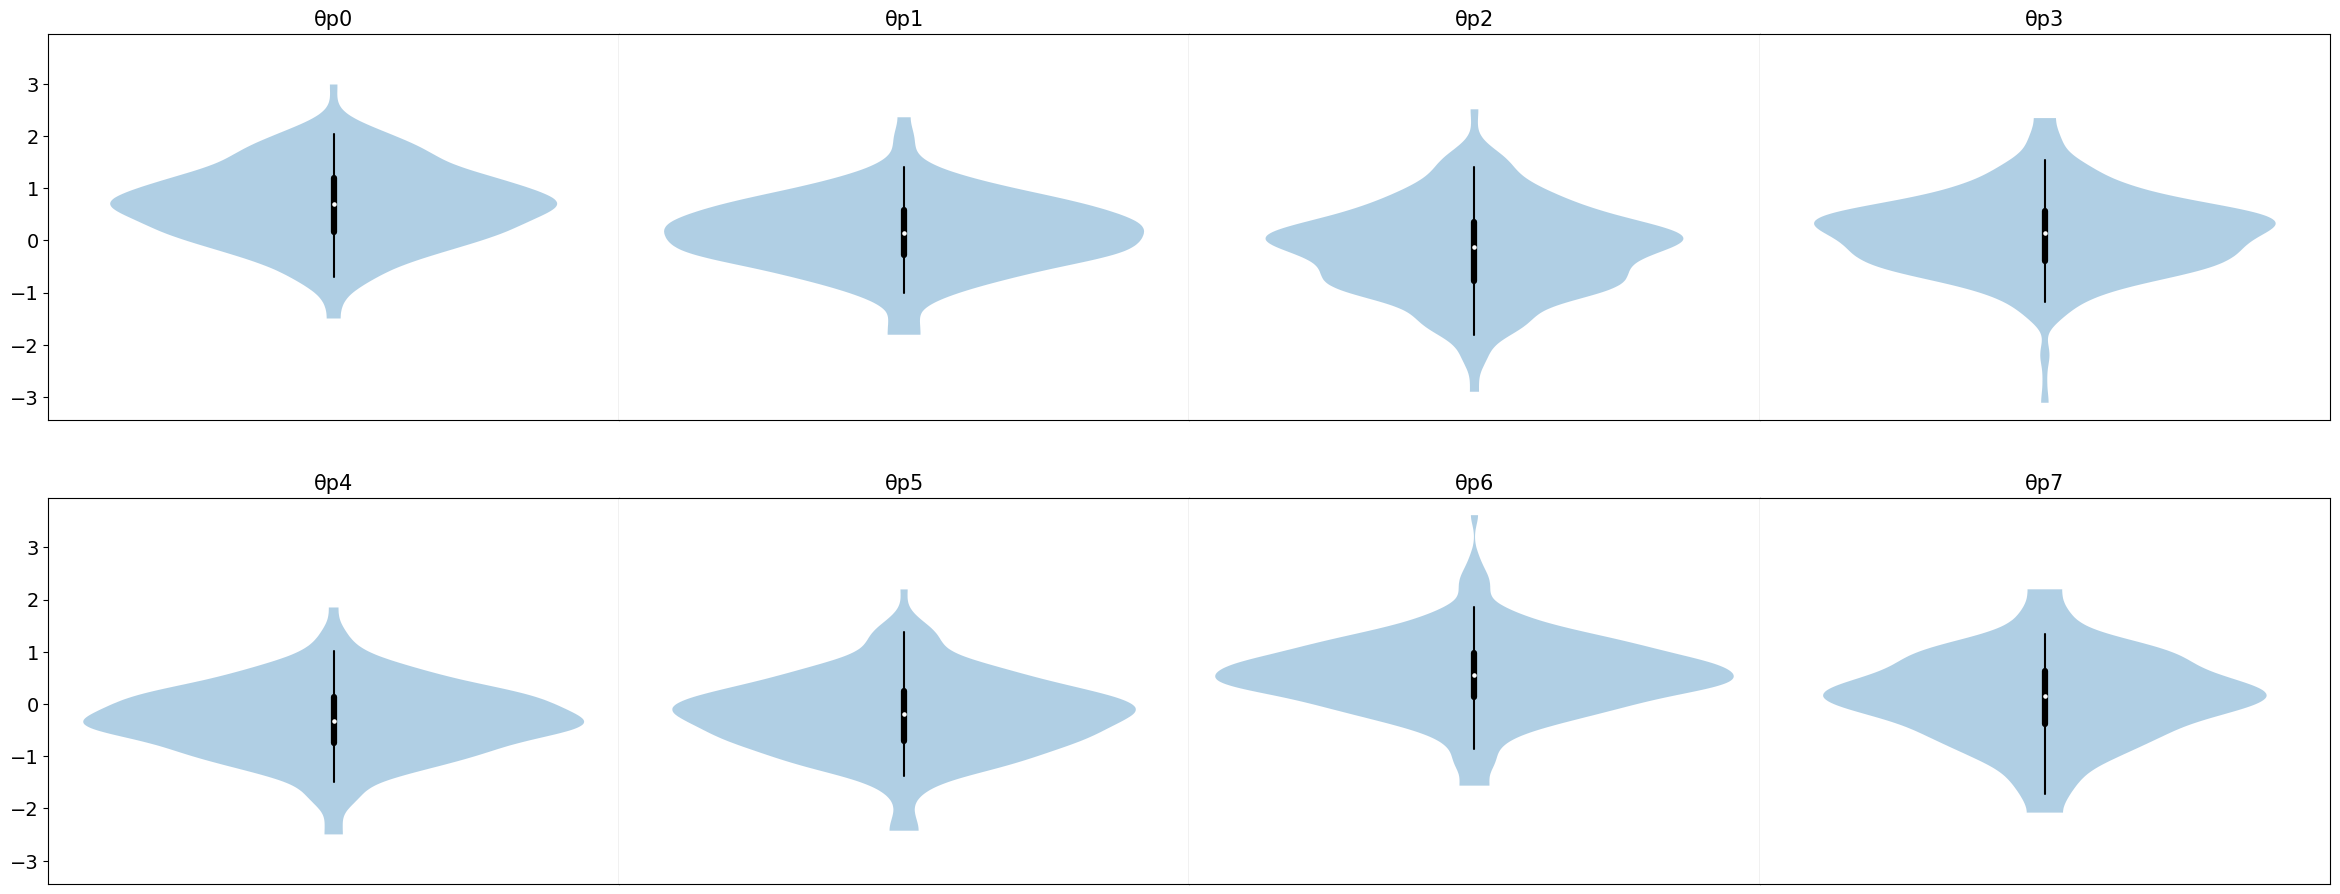

In [26]:
# Plot posterior samples
samples["θp"].plot_violin(); 
print(samples["μ"].mean()) # Average effect
print(samples["τ"].mean()) # Average variance

Main point is that CUQIpy-PyTorch is very flexible and can be used to sample from any combination of distributions.

## 4. Bayesian inverse problems with CUQIpy-PyTorch <a class=" anchor" id="bayesian-inverse-problems"></a>

We now turn our attention to Bayesian inverse problems. To start as a sanity check we can use a testproblem from the main CUQIpy package and compare with. Here we consider the a deconvolution problem with Bayesian model:

$$
\begin{align*}
\mathbf{x} &\sim \mathcal{N}(\mathbf{0}, 0.2 \mathbf{I}_n)\\
\mathbf{y} &\sim \mathcal{N}(\mathbf{A}\mathbf{x}, 0.05 \mathbf{I}_m)
\end{align*}
$$

where $\mathbf{y}$ and $\mathbf{x}$ are random variables and $\mathbf{A}\in\mathbb{R}^{m\times n}$ is a known convolution matrix.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is a work-in-progress. !!!
!!!       Always validate the computed results.        !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct sampling of Gaussian posterior. Only works for small-scale problems with dim<=2000.
No burn-in needed for direct sampling.
 Sample 1000 / 1000
Elapsed time: 0.015424966812133789


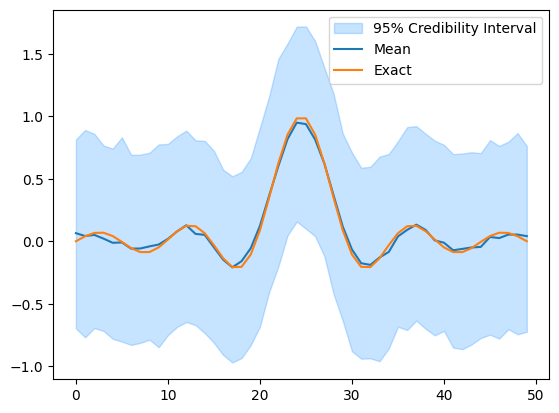

In [27]:
A, y_data, probinfo = cuqi.testproblem.Deconvolution1D(dim=50, phantom="sinc", use_legacy=True).get_components()

# CUQIpy Bayesian model
x = cuqi.distribution.Gaussian(np.zeros(A.domain_dim), cov=0.2)
y = cuqi.distribution.Gaussian(A@x, cov=0.05)

BP = cuqi.problem.BayesianProblem(y, x).set_data(y=y_data)
samples = BP.sample_posterior(1000) # Automatic sampler selection

samples.plot_ci(exact=probinfo.exactSolution)

Because we utilize the structure of the problem in CUQIpy, the sampling is very fast.

We can write the same model in CUQIpy-PyTorch as shown below. Note here that we have to add the forward model `A` to the autograd framework of PyTorch. There is a function `cuqipy_pytorch.add_forward_model` that does this for us. This requires the CUQIpy forward model to have gradient defined.

Sample: 100%|██████████| 1000/1000 [02:01,  8.26it/s, step size=5.29e-02, acc. prob=0.922]


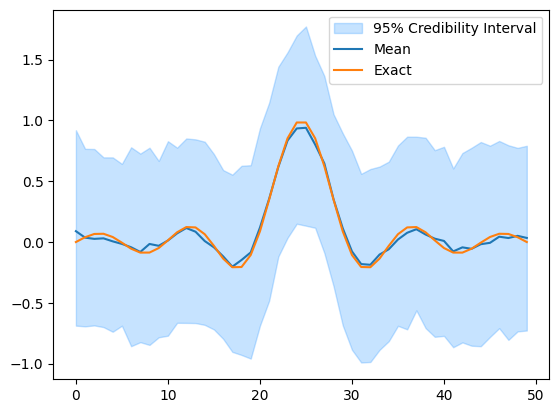

In [28]:
# CUQIpy test problem
A, y_data, probinfo = cuqi.testproblem.Deconvolution1D(dim=50, phantom="sinc", use_legacy=True).get_components()

# Add forward model to PyTorch automatic differentiation framework
A = cuqipy_pytorch.model.add_to_autograd(A)

# CUQIpy-PyTorch Bayesian model
x = Gaussian(xp.zeros(A.domain_dim), 0.2)
y = Gaussian(A(x), 0.05)

samples = sample(x, y, y=y_data)

samples["x"].plot_ci(exact=probinfo.exactSolution)

The sampling is likely to take a bit longer because we do not utilize the structure of the problem. 

However, in the CUQIpy-PyTorch version, we are free to modify any expressions for the distributions.

For example, suppose that we wanted to square the entries of $\mathbf{x}$ before evaluating $\mathbf{A}$ for whatever reason, i.e. the model would be

$$
\begin{align*}
\mathbf{x} &\sim \mathcal{N}(\mathbf{0}, 0.2 \mathbf{I}_n)\\
\mathbf{y} &\sim \mathcal{N}(\mathbf{A}(\mathbf{x}^2), 0.05 \mathbf{I}_m)
\end{align*}
$$

This would not be possible with CUQIpy, as we can see here



In [29]:
# CUQIpy test problem
A, y_data, probinfo = cuqi.testproblem.Deconvolution1D(dim=50, phantom="sinc", use_legacy=True).get_components()

# CUQIpy Bayesian model
x = cuqi.distribution.Gaussian(np.zeros(A.domain_dim), cov=0.2)
y = cuqi.distribution.Gaussian(lambda x: A@(x**2), cov=0.05)

BP = cuqi.problem.BayesianProblem(y, x).set_data(y=y_data)
try:
    samples = BP.sample_posterior(1000) # Sampling fails because of the nonlinearity
except Exception as e:
    print(e) # The error message could be improved

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is a work-in-progress. !!!
!!!       Always validate the computed results.        !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

'NoneType' object has no attribute 'domain_dim'


However, using CUQIpy-PyTorch we can easily do this.

In [30]:
# CUQIpy test problem
A, y_data, probinfo = cuqi.testproblem.Deconvolution1D(dim=50, phantom="sinc", use_legacy=True).get_components()

# Add forward model to PyTorch automatic differentiation framework
A = cuqipy_pytorch.model.add_to_autograd(A)

# CUQIpy-PyTorch Bayesian model
x = Gaussian(xp.zeros(A.domain_dim), 0.2)
y = Gaussian(lambda x: A(x**2), np.ones(A.range_dim)*0.05)

samples = sample(x, y, y=y_data)

Sample: 100%|██████████| 1000/1000 [06:01,  2.77it/s, step size=1.84e-02, acc. prob=0.921]


Note that this is not going to be a good model for this problem, but only added for illustration purposes.

# 5. Open-ended exploration <a class="anchor" id="open-ended-exploration"></a>

With the tools in place, try exploring the following:

- Try playing around with the expression for the forward model in the deconvolution problem. Can you enforce non-negativity on the entries of $\mathbf{x}$? You may want to switch the phantom to one with non-negative entries only.
- Try including other parameters such as noise or prior variance in the Bayesian model and sample it again. These need not be Gamma distributions, but can be any distribution you want.
- Try sampling from the eight schools model with different priors on $\mu$ and $\tau$.
- Try your own problem.
